# Fraud Classification Exercise `Random Forest`

In this notebook, I investigate the effect of using `class_weight='balanced'` to address **class imbalance** in machine learning models. This technique automatically adjusts the weights of the classes during model training, helping to mitigate the bias toward the majority class and improve the model’s performance on imbalanced datasets. 

We will evaluate the model's performance and assess the effectiveness of this adjustment across different methods, including the `Train-Test Split` and `StratifiedKFold cross-validation techniques`.

**Dataset:** [NHIS Healthcare Claims and Fraud Dataset](https://www.kaggle.com/datasets/bonifacechosen/nhis-healthcare-claims-and-fraud-dataset)


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Become one with the Data

In [2]:
# Step 1: Load the dataset
df = pd.read_csv('NHIS_Healthcare_Claims_and_Fraud_Dataset.csv', sep=';')
df.head()

,patient_id,age,gender,admitted,discharge,diagnose,treatment,amount_billed,fraud_type
0,9b484756-3a0d-47f4-ada3-fb63ed2d1082,82,Male,06/02/2023,06/02/2023,Appendectomy,Appendectomy,144764.37,No Fraud
1,0240f93e-8c46-4c2a-a4cb-827ecf527d36,29,Male,03/09/2022,04/09/2022,Cesarean Section,Fake Cesarean Section,531434.03,Fake Treatment
2,0e0e0476-cf0f-4b87-828c-a34bdd780e68,70,Male,02/10/2022,17/10/2022,Advanced Spinal Surgery,Phantom Procedure,128604.41,Phantom Billing
3,ad669adf-568d-4346-b60e-a26a3374f00d,12,Male,15/11/2023,20/11/2023,Peptic Ulcer,Peptic Ulcer,304989.18,No Fraud
4,9c0cc9c5-ff6f-442b-9c25-60ad3f1a4400,72,Male,15/11/2022,04/12/2022,Appendectomy,Appendectomy,277021.33,No Fraud


In [3]:
# Assuming you want value counts for multiple columns:
columns_to_check = ['fraud_type', 'diagnose', 'treatment']

# Apply value_counts to each column
value_counts_per_column = {col: df[col].value_counts() for col in columns_to_check}

# To display the results
for column, counts in value_counts_per_column.items():
    print(f"Value counts for {column}:\n{counts}\n")


Value counts for fraud_type:
fraud_type
No Fraud           887
Fake Treatment     243
Phantom Billing    206
Ghost Enrollee     164
Name: count, dtype: int64

Value counts for diagnose:
diagnose
Tuberculosis                   103
HIV/AIDS                       102
Pneumonia                      102
Asthma                         101
Hepatitis B                     98
Peptic Ulcer                    93
Diabetes                        90
Gastroenteritis                 90
Cesarean Section                90
Hypertension                    90
Appendectomy                    85
Cataract Surgery                84
Stroke                          84
Kidney Disease                  82
Infertility Treatment (IVF)     33
Cancer Treatment                30
Cosmetic Surgery                27
Complex Heart Surgery           26
Advanced Spinal Surgery         23
Organ Transplant                23
Epilepsy Surgery                23
Neurosurgery                    21
Name: count, dtype: int64

Value co

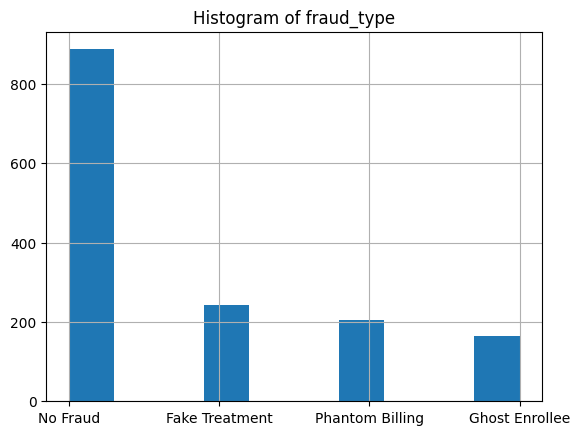

In [4]:
# Plot histogram for a column (e.g., 'A')
df['fraud_type'].hist(bins=10)
plt.title('Histogram of fraud_type')
plt.show()

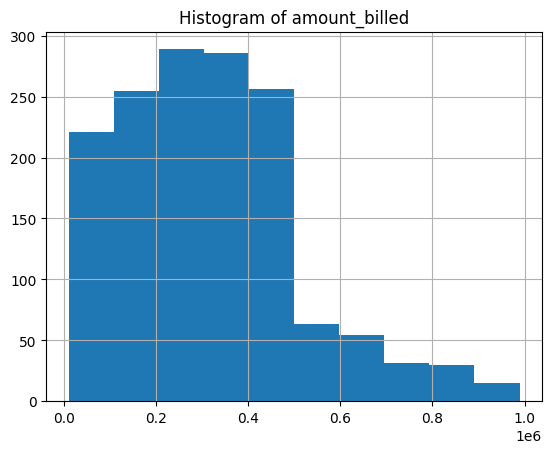

In [5]:
# Plot histogram for a column (e.g., 'A')
df['amount_billed'].hist(bins=10)
plt.title('Histogram of amount_billed')
plt.show()

In [6]:
# Step 2: Preprocess the data

# Convert 'admitted' and 'discharge' to datetime to extract useful features (e.g., duration of stay)
df['admitted'] = pd.to_datetime(df['admitted'], format='%d/%m/%Y')
df['discharge'] = pd.to_datetime(df['discharge'], format='%d/%m/%Y')
df.head()

,patient_id,age,gender,admitted,discharge,diagnose,treatment,amount_billed,fraud_type
0,9b484756-3a0d-47f4-ada3-fb63ed2d1082,82,Male,2023-02-06,2023-02-06,Appendectomy,Appendectomy,144764.37,No Fraud
1,0240f93e-8c46-4c2a-a4cb-827ecf527d36,29,Male,2022-09-03,2022-09-04,Cesarean Section,Fake Cesarean Section,531434.03,Fake Treatment
2,0e0e0476-cf0f-4b87-828c-a34bdd780e68,70,Male,2022-10-02,2022-10-17,Advanced Spinal Surgery,Phantom Procedure,128604.41,Phantom Billing
3,ad669adf-568d-4346-b60e-a26a3374f00d,12,Male,2023-11-15,2023-11-20,Peptic Ulcer,Peptic Ulcer,304989.18,No Fraud
4,9c0cc9c5-ff6f-442b-9c25-60ad3f1a4400,72,Male,2022-11-15,2022-12-04,Appendectomy,Appendectomy,277021.33,No Fraud


In [7]:
# Create a new feature for the duration of stay (in days)
df['stay_duration'] = (df['discharge'] - df['admitted']).dt.days

# Drop 'admitted' and 'discharge' columns since we now have 'stay_duration'
df = df.drop(['admitted', 'discharge'], axis=1)

# Drop non-numeric columns like 'patient_id'
df = df.drop('patient_id', axis=1)

df.head()

,age,gender,diagnose,treatment,amount_billed,fraud_type,stay_duration
0,82,Male,Appendectomy,Appendectomy,144764.37,No Fraud,0
1,29,Male,Cesarean Section,Fake Cesarean Section,531434.03,Fake Treatment,1
2,70,Male,Advanced Spinal Surgery,Phantom Procedure,128604.41,Phantom Billing,15
3,12,Male,Peptic Ulcer,Peptic Ulcer,304989.18,No Fraud,5
4,72,Male,Appendectomy,Appendectomy,277021.33,No Fraud,19


In [8]:
# Encode categorical columns (e.g., 'gender', 'diagnose', 'fraud_type') using LabelEncoder
encoder = LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])
df['diagnose'] = encoder.fit_transform(df['diagnose'])
df['treatment'] = encoder.fit_transform(df['treatment'])
df['fraud_type'] = encoder.fit_transform(df['fraud_type'])  # Target variable
df.head()

,age,gender,diagnose,treatment,amount_billed,fraud_type,stay_duration
0,82,1,1,0,144764.37,2,0
1,29,1,5,8,531434.03,0,1
2,70,1,0,25,128604.41,3,15
3,12,1,18,24,304989.18,2,5
4,72,1,1,0,277021.33,2,19


In [9]:
df['gender'].unique()

array([1, 0])

In [10]:
# Step 3: Split the data into features (X) and target (y)
X = df.drop('fraud_type', axis=1)  # Features (exclude fraud_type)
y = df['fraud_type']  # Target variable

## Train Parameter

In [11]:
N_ESTIMATOR=89
RANDOM_STATE=42

# Manually specify class weights. <== uSE THIS FOR MANUAL CLASS WEIGHTS
CLASS_WEIGHTS = {
    0: 1,     # No Fraud (majority class)
    1: 3,     # Fake Treatment (minority class)
    2: 3,     # Phantom Billing (minority class)
    3: 4      # Ghost Enrollee (most minority class)
}

## Train Test Split Method

In [12]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Step 4: Train the Random Forest model
rf_model_tt = RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE, class_weight='balanced')
rf_model_tt.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=89,
                       random_state=42)

Accuracy Score: 0.8933
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.00      0.00      0.00        29
           2       0.86      0.98      0.92       188
           3       1.00      1.00      1.00        33

    accuracy                           0.89       300
   macro avg       0.72      0.75      0.73       300
weighted avg       0.82      0.89      0.85       300



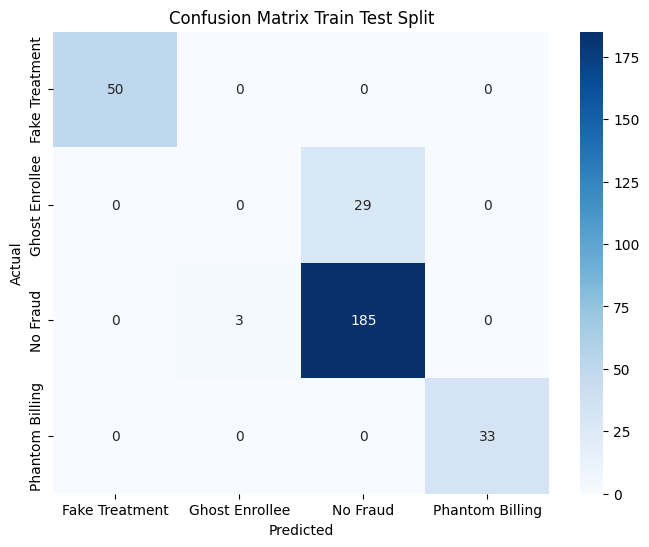

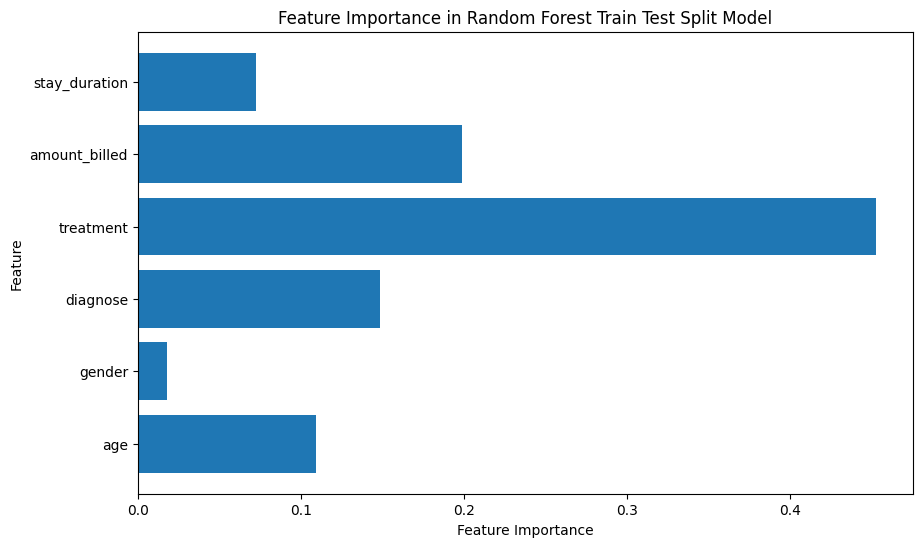

In [14]:
# Step 5: Make predictions
y_pred = rf_model_tt.predict(X_test)

# Step 6: Evaluate the model

# Accuracy score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix Train Test Split")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 7: Plot Training Accuracy Over Iterations (For Random Forest, we can show feature importance)
# Random Forest doesn't provide a typical "training loss" curve like neural networks, but we can visualize feature importances:
feature_importance = rf_model_tt.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Train Test Split Model")
plt.show()



## StratifiedKFold Method

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

In [16]:
# Initialize the StratifiedKFold with 5 splits
kf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

# Initialize the RandomForestClassifier with class_weight='balanced'
rf_model_skf = RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE, class_weight='balanced')

In [17]:
# Variables to store accuracies and predictions
accuracies = []
y_true_all = []  # To collect all true labels
y_pred_all = []  # To collect all predicted labels

# Perform Stratified K-fold Cross Validation
for train_index, test_index in kf.split(X, y):
    # Split the data into training and testing sets
    X_train_skf, X_test_skf = X.iloc[train_index], X.iloc[test_index]
    y_train_skf, y_test_skf = y.iloc[train_index], y.iloc[test_index]
    
    # Train the RandomForest model
    rf_model_skf.fit(X_train_skf, y_train_skf)
    
    # Make predictions on the test set
    y_pred_skf = rf_model_skf.predict(X_test_skf)

    # Store true and predicted values for later evaluation
    y_true_all.extend(y_test_skf)
    y_pred_all.extend(y_pred_skf)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test_skf, y_pred_skf)
    accuracies.append(accuracy)

# Print the cross-validation accuracies
print(f"Cross-validation accuracies: {accuracies}")
print(f"Average accuracy: {np.mean(accuracies)}")


Cross-validation accuracies: [0.87, 0.89, 0.86, 0.89, 0.89, 0.88, 0.89, 0.89, 0.89, 0.89, 0.89, 0.88, 0.88, 0.88, 0.88]
Average accuracy: 0.8833333333333335



Average Accuracy across all folds: 0.8833

Final Classification Report (Across all folds):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       0.08      0.01      0.01       164
           2       0.84      0.99      0.91       887
           3       1.00      1.00      1.00       206

    accuracy                           0.88      1500
   macro avg       0.73      0.75      0.73      1500
weighted avg       0.81      0.88      0.84      1500



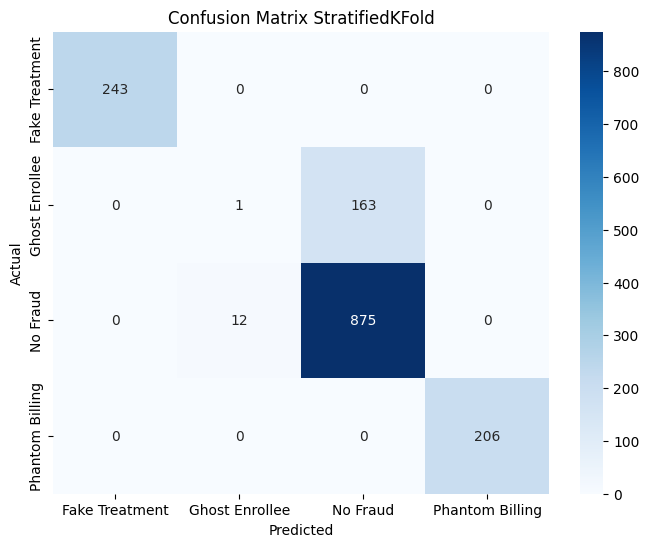

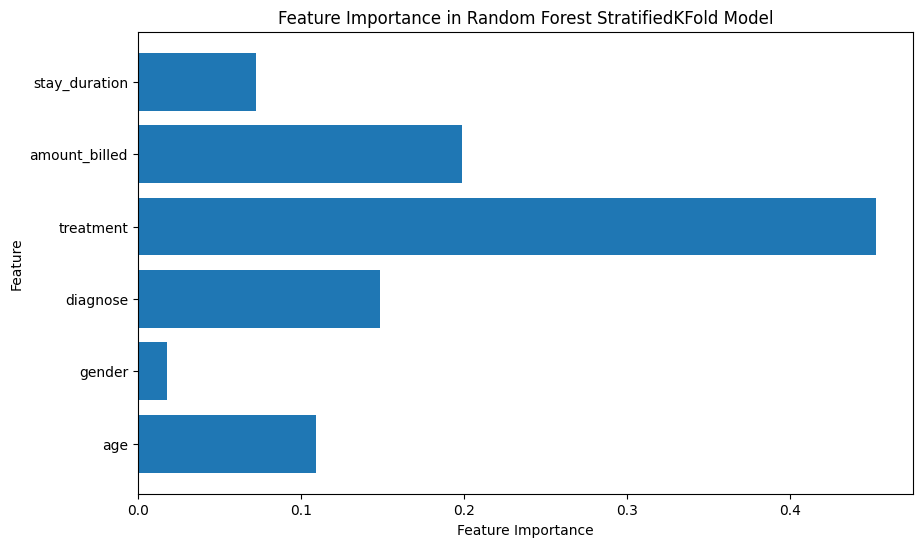

In [18]:
# Step 1: Final Classification Report after all folds
print(f"\nAverage Accuracy across all folds: {np.mean(accuracies):.4f}")

# Step 2: Report Final Average Accuracy Across Folds
print(f"\nFinal Classification Report (Across all folds):\n", classification_report(y_true_all, y_pred_all))

# Step 3: Confusion Matrix after cross-validation
cm_skf = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_skf, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix StratifiedKFold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 4: Feature Importance (Random Forest Specific)
feature_importance = rf_model_tt.feature_importances_

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest StratifiedKFold Model")
plt.show()

## Conclusion:

* Both of method struggle to handle class 1 (Fake Treatment)
* StratifiedKFold Method give better result when handle class 1 (Fake Treatment)

So if I have to choose, then I would go with `SKF model`, but for better result we should `rebalanced` the dataset

In [19]:
# Get classification reports as dictionaries
report_a = classification_report(y_test, y_pred, output_dict=True)
report_b = classification_report(y_true_all, y_pred_all, output_dict=True)

# Extract the weighted average values from each report
weighted_avg_a = report_a['weighted avg']
weighted_avg_b = report_b['weighted avg']

# Prepare a DataFrame with the weighted averages of both reports
weighted_avg_df = pd.DataFrame({
    'Metric': ['precision', 'recall', 'f1-score'],
    'Train Test': [weighted_avg_a['precision'], weighted_avg_a['recall'], weighted_avg_a['f1-score']],
    'SKF': [weighted_avg_b['precision'], weighted_avg_b['recall'], weighted_avg_b['f1-score']],
})

# Print the DataFrame
print(weighted_avg_df)

      Metric  Train Test       SKF
0  precision    0.818411  0.806218
1     recall    0.893333  0.883333
2   f1-score    0.853449  0.838144
